# Dataset 1

In [3]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

# load dataset from csv
dataset = pd.read_csv('network_backup_dataset.csv')
data = []
weekdays = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

for i in range(len(dataset)):
    temp = dataset.loc[i]
    day = weekdays[temp[1]] + (temp[0]-1)*7
    
    if len(data) == day:
        data.append([0,0,0,0,0])
        
    workflow = int(temp[3][10:])
    data[day][workflow] += temp[5]
    
data = np.array(data)

def printWorkflows(data, n_days):
    plt.figure(figsize=(15,8))
    N = data.shape[1]
    x = range(1,n_days+1)
    for k in range(N):
        plt.plot(x, data[0:n_days, k], label='work flow ' + str(k))

    plt.xlabel('Day')
    plt.ylabel('Backup Sizes (GB)')
    plt.title('Backup Sizes (first 20 days)')
    plt.xlim([1, n_days])
    plt.legend()
    plt.show()

# 1(a)
    

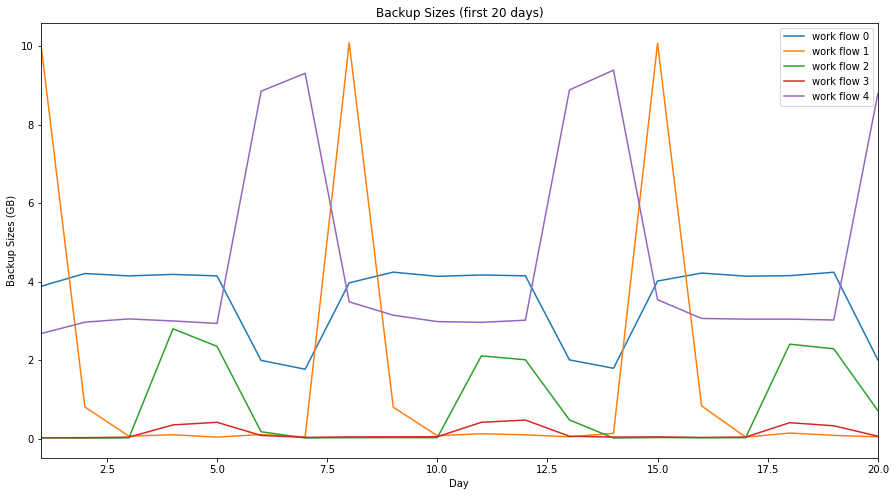

In [7]:
printWorkflows(data, 20)

# 1(b)

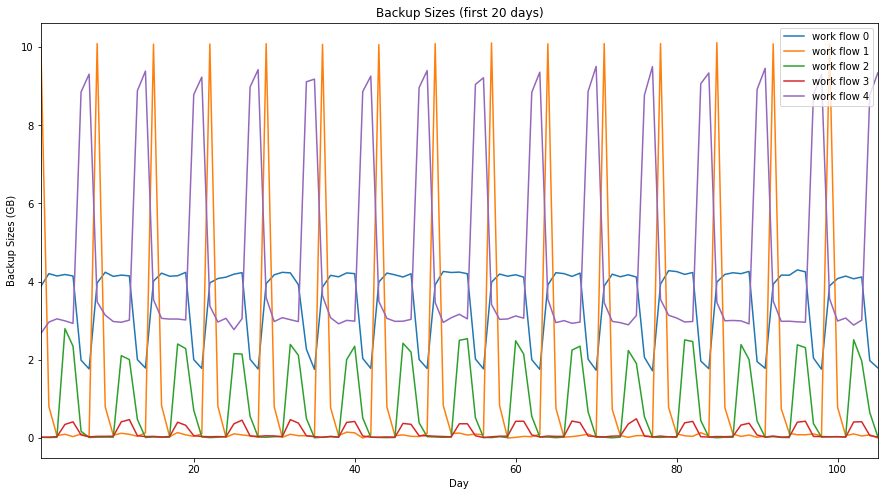

In [8]:
printWorkflows(data, 105)

# 1(c)

The workflows in both 20-day and 105-day plots are periodic with a period for each workflow to be about 7 days. Workflow_1 always have the largest backup size, followed by workflow_4, workflow_0, workflow_2, and workflow_3. 

# 2(a)

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error

# preprocessing
dataset = dataset.replace({'Day of Week':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}})
workflow = {}
file = {}

for j in dataset['File Name']:
    file[j] = int(j[5:])
    
for k in dataset['Work-Flow-ID']:
    workflow[k] = int(k[10:])

# replace int-strings with integers 
dataset = dataset.replace({'Work-Flow-ID':workflow})
dataset = dataset.replace({'File Name':file})

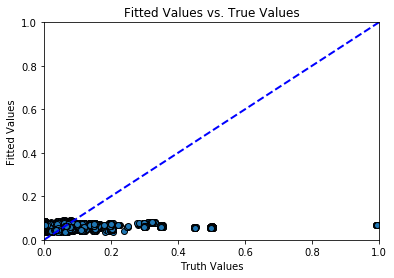

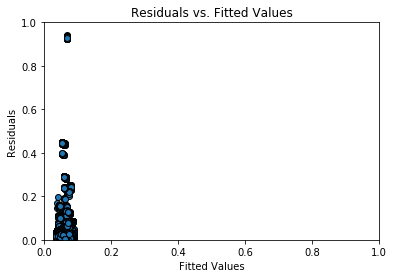

Training RMSE:  [0.10324315757540427, 0.10396677791654478, 0.10322579905879994, 0.1039464291963174, 0.10319511299798963, 0.10393838251390547, 0.10320263162336227, 0.10393638595896813, 0.10320098997274793, 0.10399160058862011]
Test RMSE:  [0.10671805207226825, 0.10018461438631411, 0.106849773893365, 0.10036709167781363, 0.10711585431838347, 0.10044533654683797, 0.10705026882029617, 0.1004666455097133, 0.10707418586815101, 0.09994712086112156]
Average training RMSE: 0.10358539364277801
Average test RMSE: 0.1036758476759903


In [36]:
# Basic linear regression model
kf = KFold(n_splits=10)
train_RMSE, test_RMSE, pred, truth = [], [], [], []

for i, j in kf.split(dataset.values):
    model = LinearRegression()
    train, test = dataset.values[i], dataset.values[j]
    model.fit(train[:,[0,1,2,3,4]], train[:,5])
    
    train_pred = model.predict(train[:,[0,1,2,3,4]])
    train_truth = train[:,5]
    train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
    test_pred = model.predict(test[:,[0,1,2,3,4]])
    test_truth = test[:,5]
    test_RMSE.append(mean_squared_error(test_truth, test_pred))
    
    pred.extend(test_pred.tolist())
    truth.extend(test_truth.tolist())
    
residual = []
for i in range(len(pred)):
    residual.append(abs(truth[i] - pred[i]))

# pred vs. truth
# draw a diagonal line for comparison
plt.plot([0,1], [0,1], 'b--', lw=2)
plt.scatter(truth, pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

# residual
plt.scatter(pred, residual, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# report training RMSE and test RMSE
def getSqrt(RMSE):
    result = []
    for i in range(len(RMSE)):
        result.append(math.sqrt(RMSE[i]))
    return result

print('Training RMSE: ', getSqrt(train_RMSE))
print('Test RMSE: ', getSqrt(test_RMSE))
print('Average training RMSE:', math.sqrt(np.mean(train_RMSE)))
print('Average test RMSE:', math.sqrt(np.mean(test_RMSE)))

From the plots, we observe that the predicted value using the basic linear regression model centered at around 0.061 and the residuals centered at around 0.064. This implies that our model does not predict very well, as ideally we would want the first plot to mirror at the line y = x. 

# 2(b)

From the plots, we observe that the predicted value using the random forest regression model predicts better than the basic linear regression model, because the fitted values vs. true values roughly mirror at the line y = x. 

Progress: 

Number of features =  1
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  2
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  3
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  4
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  5
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200


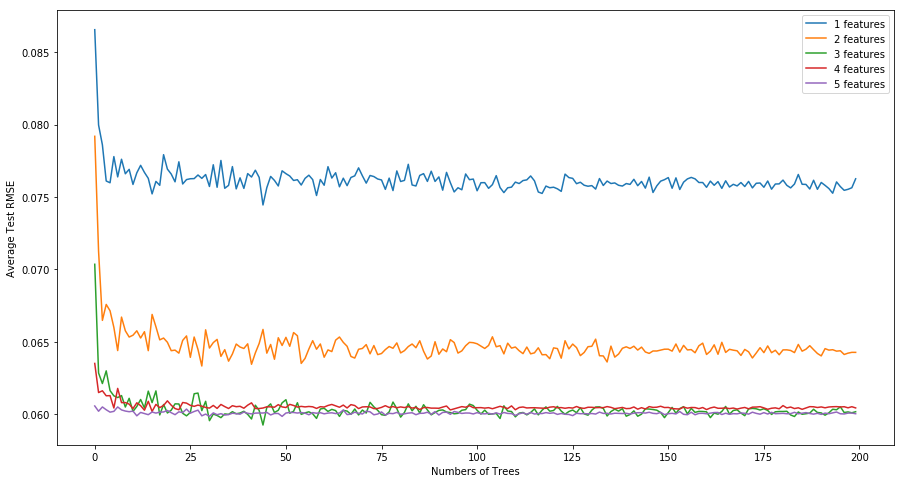

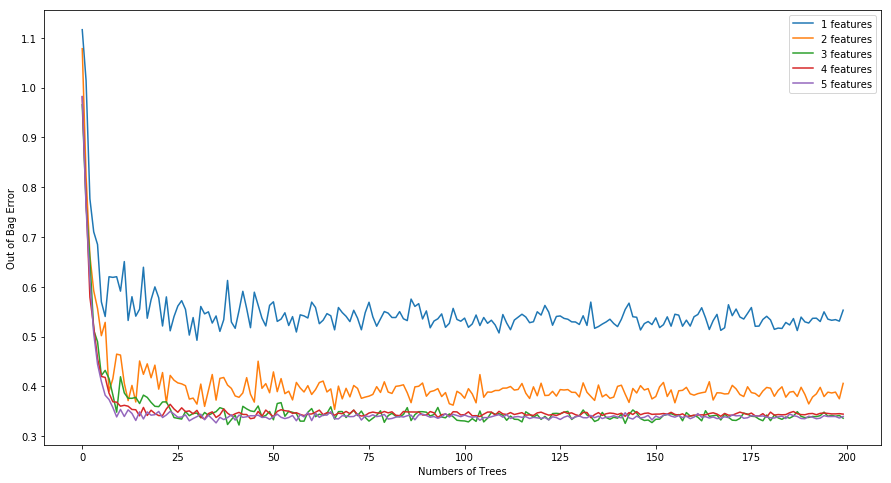

In [13]:
# random forest regression algorithm

print('Progress: ')
print()

for k in range(5): # num of features
    OOB = []
    avg_test_RMSE = []
    print('Number of features = ', k+1)
    
    for t in range(200): # num of trees
        if((t+1)%50 == 0):
            print('Number of trees = ', t+1)
            
        kf = KFold(n_splits=10)
        train_RMSE, test_RMSE = [], []
        
        for i, j in kf.split(dataset.values):
            model = RandomForestRegressor(n_estimators=t+1, max_features=k+1, max_depth=4, bootstrap=True, oob_score=True)
            train, test = dataset.values[i], dataset.values[j]
            model.fit(train[:,[0,1,2,3,4]], train[:,5])
            
            train_pred = model.predict(train[:,[0,1,2,3,4]])
            train_truth = train[:,5]
            train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
            test_pred = model.predict(test[:,[0,1,2,3,4]])
            test_truth = test[:,5]
            test_RMSE.append(mean_squared_error(test_truth, test_pred))

        oob_score = model.oob_score_ 
        OOB.append(1-oob_score)
        avg_test_RMSE.append(math.sqrt(np.mean(test_RMSE)))
        
    plt.figure(figsize=(15,8))
    plt.figure(1)       
    plt.plot(avg_test_RMSE, label = str(k+1) + ' features')
    plt.xlabel('Numbers of Trees')
    plt.ylabel('Average Test RMSE')
    plt.legend(loc='upper right')
    
    plt.figure(figsize=(15,8))
    plt.figure(2)
    plt.plot(OOB, label = str(k+1) + ' features')
    plt.xlabel('Numbers of Trees')
    plt.ylabel('Out of Bag Error')    
    plt.legend(loc='upper right')
    
plt.show()

From the above plots, we observe that 4 and 5 features would yield the smallest average test RMSE and out of bag error. Furthermore, for out of bag errors, using 4 features would give a less fluctuated out of bag error compared to using 5 features. Additionally, for both average test RMSE and out of bag errors, the values decreases to steady state errors when the number of trees takes values greater than or equal to 20. 

Progress: 

Max depth =  1
Max depth =  2
Max depth =  3
Max depth =  4
Max depth =  5
Max depth =  6
Max depth =  7
Max depth =  8
Max depth =  9
Max depth =  10
Max depth =  11
Max depth =  12
Max depth =  13
Max depth =  14
Max depth =  15
Max depth =  16
Max depth =  17
Max depth =  18
Max depth =  19
Max depth =  20


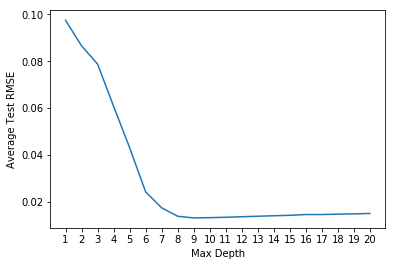

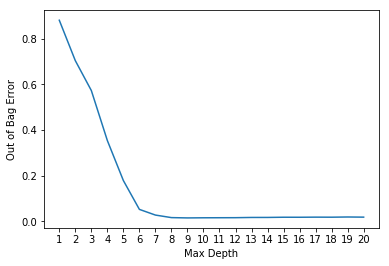

In [14]:
# sweep for max depth for better performance from 1 to 20
# set num of trees = 25 and num of features = 4

print('Progress: ')
print()

OOB = []
avg_test_RMSE = []
    
for d in range(20): # max depth
    print('Max depth = ', d+1)
    
    kf = KFold(n_splits=10)
    train_RMSE, test_RMSE = [], []
    
    for i, j in kf.split(dataset.values):
        model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=d+1, bootstrap=True, oob_score=True)
        train, test = dataset.values[i], dataset.values[j]
        model.fit(train[:,[0,1,2,3,4]], train[:,5])
        
        train_pred = model.predict(train[:,[0,1,2,3,4]])
        train_truth = train[:,5]
        train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
        test_pred = model.predict(test[:,[0,1,2,3,4]])
        test_truth = test[:,5]
        test_RMSE.append(mean_squared_error(test_truth, test_pred))
        
    oob_score = model.oob_score_ 
    OOB.append(1-oob_score)
    avg_test_RMSE.append(math.sqrt(np.mean(test_RMSE)))
    
plt.figure(1)       
plt.plot(np.arange(1,21), avg_test_RMSE)
plt.xticks(np.arange(1,21))
plt.xlabel('Max Depth')
plt.ylabel('Average Test RMSE')

plt.figure(2)
plt.plot(np.arange(1,21), OOB)
plt.xticks(np.arange(1,21))
plt.xlabel('Max Depth')
plt.ylabel('Out of Bag Error')    

plt.show()

We choose to tune the max depth. From the plots, we see that the average test RMSE and out of bag error decrease to their steady state values for max depths greater than or equal to 8. Therefore, the parameters that achieves the best performance is {tree number = 25, number of features = 4, max depth = 8}. 

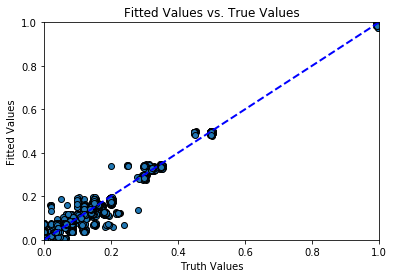

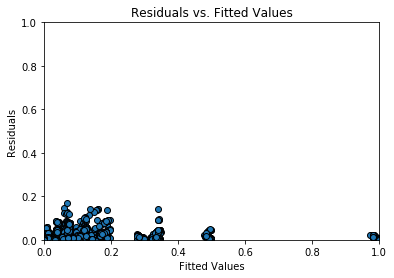

Training RMSE:  [0.01339475790484721, 0.012699002503866696, 0.01297521786677019, 0.012576066763404854, 0.012999517049814077, 0.012540059798499488, 0.013149936121275557, 0.012934212331469533, 0.013057701613763694, 0.012970943711594268]
Test RMSE:  [0.01486821955405562, 0.01437241548265735, 0.011716428514090204, 0.015142629008888159, 0.011977881382340103, 0.015537251819343376, 0.012835258170819411, 0.013860656116192794, 0.011784655311249191, 0.014114107229807453]
Average training RMSE: 0.012932138655154444
Average test RMSE: 0.013689513469914965
Out of bag error: 0.017801362330463033


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=10)
train_RMSE, test_RMSE, pred, truth = [], [], [], []

for i, j in kf.split(dataset.values):
    model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=8, bootstrap=True, oob_score=True)
    train, test = dataset.values[i], dataset.values[j]
    model.fit(train[:,[0,1,2,3,4]], train[:,5])
    
    train_pred = model.predict(train[:,[0,1,2,3,4]])
    train_truth = train[:,5]
    train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
    test_pred = model.predict(test[:,[0,1,2,3,4]])
    test_truth = test[:,5]
    test_RMSE.append(mean_squared_error(test_truth, test_pred))
    
    pred.extend(test_pred.tolist())
    truth.extend(test_truth.tolist())
    
residual = []
for i in range(len(pred)):
    residual.append(abs(truth[i] - pred[i]))

# pred vs. truth
# draw a diagonal line for comparison
plt.plot([0,1], [0,1], 'b--', lw=2)
plt.scatter(truth, pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

# residual
plt.scatter(pred, residual, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

def getSqrt(RMSE):
    result = []
    for i in range(len(RMSE)):
        result.append(math.sqrt(RMSE[i]))
    return result

print('Training RMSE: ', getSqrt(train_RMSE))
print('Test RMSE: ', getSqrt(test_RMSE))
print('Average training RMSE:', math.sqrt(np.mean(train_RMSE)))
print('Average test RMSE:', math.sqrt(np.mean(test_RMSE)))

oob_score = model.oob_score_ 
print("Out of bag error:", 1 - oob_score)

In [15]:
# feature importance

x = pd.DataFrame(dataset.iloc[:, [0,1,2,3,4]].values)
y = dataset.iloc[:, 5].values

model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=8, bootstrap=True, oob_score=True, random_state=1)
model.fit(x, y)
importance = model.feature_importances_
N = len(importance)

M = np.linspace(1, N, N)
temp = np.vstack((M,importance)).T
sort_f = sorted(temp, key=lambda x:x[1], reverse=True)

for i in range(N):
    result = sort_f[i][1]
    print('Feature', int(sort_f[i][0]-1), 'Importance = ', result)

Feature 2 Importance =  0.38933001041675014
Feature 1 Importance =  0.23359502384072703
Feature 4 Importance =  0.2084943295705703
Feature 3 Importance =  0.16679964892361154
Feature 0 Importance =  0.0017809872483410417


Based on the importance ranks, we see that the most important features are hour of the day, day of the week, file name, work-flow-ID, and week number, with descending order of feature importance. 

In [22]:
# visualize decision tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=4, bootstrap=True, oob_score=True)
model.fit(x, y)
est = model.estimators_[0]
export_graphviz(est, out_file='DecisionTree.dot')

#http://www.webgraphviz.com/

The root node in the decision tree corresponds to file name, which is not the most important feature we found in the previous part. This happens because the decision tree we realized in this part is an instance of many trees that are obtained using the random forest algorithm, in which the algorithm uses the many trees and votes on the most important feature based on these results. 

# 2(c)

relu : 
Number of hidden layers =  2
Number of hidden layers =  5
Number of hidden layers =  10
Number of hidden layers =  50
Number of hidden layers =  100
Number of hidden layers =  150
Number of hidden layers =  200
Number of hidden layers =  250
Number of hidden layers =  300
Number of hidden layers =  350
Number of hidden layers =  400
Number of hidden layers =  450
Number of hidden layers =  500
Number of hidden layers =  550
Number of hidden layers =  600
logistic : 
Number of hidden layers =  2
Number of hidden layers =  5
Number of hidden layers =  10
Number of hidden layers =  50
Number of hidden layers =  100
Number of hidden layers =  150
Number of hidden layers =  200
Number of hidden layers =  250
Number of hidden layers =  300
Number of hidden layers =  350
Number of hidden layers =  400
Number of hidden layers =  450
Number of hidden layers =  500
Number of hidden layers =  550
Number of hidden layers =  600
tanh : 
Number of hidden layers =  2
Number of hidden layers =

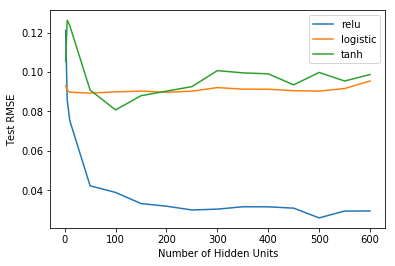

In [4]:
# NN regression model, one-hot encoding

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

dataset=pd.read_csv('network_backup_dataset.csv')

X = dataset.iloc[:, [0,1,2,3,4]].values
y = dataset.iloc[:, 5].values

label_enc = LabelEncoder()
X[:, 0] = label_enc.fit_transform(X[:, 0])
X[:, 1] = label_enc.fit_transform(X[:, 1])
X[:, 2] = label_enc.fit_transform(X[:, 2])
X[:, 3] = label_enc.fit_transform(X[:, 3])
X[:, 4] = label_enc.fit_transform(X[:, 4])

enc = OneHotEncoder()
X = enc.fit_transform(X)

hidden_layers = [2, 5, 10, 50,100,150,200,250,300,350,400,450,500,550,600]

def getRMSE(X, y, hidden_layers, activation_function):
    print(activation_function, ': ')
    
    RMSE = []
    for i in hidden_layers:
        print('Number of hidden layers = ', i)
        model = MLPRegressor(hidden_layer_sizes=i, activation=activation_function)
        scores = cross_validate(model, X, y, scoring=['neg_mean_squared_error'], cv=10, return_train_score=True)
        RMSE_test = np.mean(np.sqrt(np.abs(scores['test_neg_mean_squared_error'])))
        RMSE.append(RMSE_test)
    ax.plot(hidden_layers, RMSE, label=activation_function)
    ax.set_xlabel('Number of Hidden Units')
    ax.set_ylabel('Test RMSE')
    plt.legend()

fig, ax = plt.subplots()

getRMSE(X, y, hidden_layers, 'relu')
getRMSE(X, y, hidden_layers, 'logistic')
getRMSE(X, y, hidden_layers, 'tanh')

plt.show()


In [32]:
X = dataset.iloc[:, [0,1,2,3,4]].values
y = dataset.iloc[:, 5].values

# label encoding Day of Week 
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X[:, 1] = labelencoder_X.fit_transform(X[:, 1])
X[:, 2] = labelencoder_X.fit_transform(X[:, 2])
X[:, 3] = labelencoder_X.fit_transform(X[:, 3])
X[:, 4] = labelencoder_X.fit_transform(X[:, 4])

enc = OneHotEncoder()
X = enc.fit_transform(X)
model = MLPRegressor(hidden_layer_sizes=500, activation='relu')
scores = cross_validate(model, X, y, scoring=['neg_mean_squared_error'], cv=10, return_train_score=True)
train_RMSE = np.abs(scores['train_neg_mean_squared_error'])
test_RMSE = np.abs(scores['test_neg_mean_squared_error'])

# Splitting the dataset into the Training set and Test set
y_pred = cross_val_predict(model, X, y, cv=10)

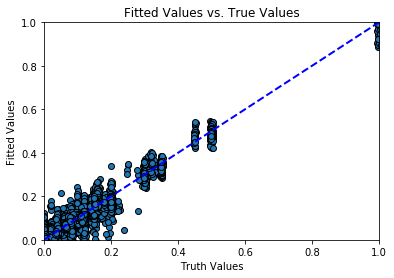

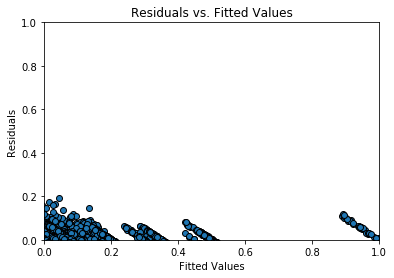

Training RMSE:  [0.014964935923638515, 0.013632019390229469, 0.01579240527404731, 0.013710585903069738, 0.015620649061258294, 0.01405486011316085, 0.015018761099988398, 0.014119997699301553, 0.014724413742444289, 0.015466858427300572]
Test RMSE:  [0.030161042672223446, 0.02098999765600241, 0.027522310858475094, 0.0411714432122026, 0.02406834955709214, 0.0348112040033641, 0.03077249981695051, 0.027415445382418642, 0.030990851978511688, 0.023270115480557862]
Average training RMSE: 0.014729816188841486
Average test RMSE: 0.029655393731562826


In [34]:
plt.plot([0,1], [0,1], 'b--', lw=2)
plt.scatter(y, y_pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

plt.scatter(y_pred, y - y_pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# report training RMSE and test RMSE
def getSqrt(RMSE):
    result = []
    for i in range(len(RMSE)):
        result.append(math.sqrt(RMSE[i]))
    return result

print('Training RMSE: ', getSqrt(train_RMSE))
print('Test RMSE: ', getSqrt(test_RMSE))
print('Average training RMSE:', math.sqrt(np.mean(train_RMSE)))
print('Average test RMSE:', math.sqrt(np.mean(test_RMSE)))

From the plots, we observe that although the points from the first plot center roughly around the line y=x, there are many points that are do not lie on the line. From the second plot, the residuals or errors of our predicted values range from 0 to a little less than 1.  We conclude that the neural network regression model works better than the basic linear regression model, but worse than the random forest regression model, as ideally we would want the points from the first plot to lie roughly at the line y = x, and the points (residuals) from the second plot to be as close to 0 as possible. 